In [110]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import glob
import seaborn as sns
import sys
import copy
from tqdm.notebook import tqdm
from numba import jit
from scipy import stats
import networkx as nx
import random
import re
from validation_functions import *
from numba import njit

plt.style.use('seaborn-deep')
plt.rcParams["text.usetex"] = True
plt.rcParams['text.latex.preamble'] = r'\usepackage{amssymb,amsmath}'

plt.rcParams["figure.figsize"] = 11.7, 8.3
plt.rcParams["figure.dpi"] = 75

plt.rcParams["font.size"] = 22
plt.rcParams["font.family"] = "sans-serif"
plt.rcParams["font.sans-serif"] = ["Fira Sans", 'PT Sans', 'Open Sans', 'Roboto', 'DejaVu Sans', 'Liberation Sans', 'sans-serif']

plt.rcParams["legend.frameon"] = True
plt.rcParams["legend.fancybox"] = True
plt.rcParams["legend.fontsize"] = "small"

plt.rcParams["lines.linewidth"] = 2.5
plt.rcParams["lines.markersize"] = 14
plt.rcParams["lines.markeredgewidth"] = 2

plt.rcParams["xtick.major.size"] = 8
plt.rcParams["ytick.major.size"] = 8

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


/tmp/ipykernel_367221/4211290353.py:20: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-deep')


In [185]:
def read_inf_coords(dim, path):
    df = pd.read_csv(path, sep="\s+", header=None, comment="#")
    if dim == 1:
        df.columns = ['index', 'inf_kappa', 'inf_theta', 'inf_radius']
    else:
        cols = [f'inf_p{i}' for i in range(dim+1)]
        df.columns = ['index', 'inf_kappa', 'inf_radius', *cols]
    return df


def read_all_coordinates(dim ,folder):
    inf_coord_files = glob.glob(f'{folder}/*inf_coord*')
    for file in inf_coord_files:
        if 'features_le' in file:
            inf_coord_features_le = read_inf_coords(dim, file)
        elif 'nodes_le' in file:
            inf_coord_nodes_le = read_inf_coords(dim, file)
        elif 'features' in file:
            inf_coord_features = read_inf_coords(dim, file)
        elif 'nodes' in file:
            inf_coord_nodes = read_inf_coords(dim, file)
        elif '_raw' in file:
            ''
        elif 'coord_le' in file:
            inf_coord_le = read_inf_coords(dim, file)
        else:
            inf_coord = read_inf_coords(dim, file)
        
    # Merge inferred and generated coordinates
    # 1. Coordinates of nodes in bipartite
    # 2. Coordinates of features in bipartite
    df_nodes = inf_coord_nodes.merge(inf_coord_nodes_le, on='index', suffixes=('', '_le'))
    df_features = inf_coord_features.merge(inf_coord_features_le, on='index', suffixes=('', '_le'))
    return df_nodes, df_features

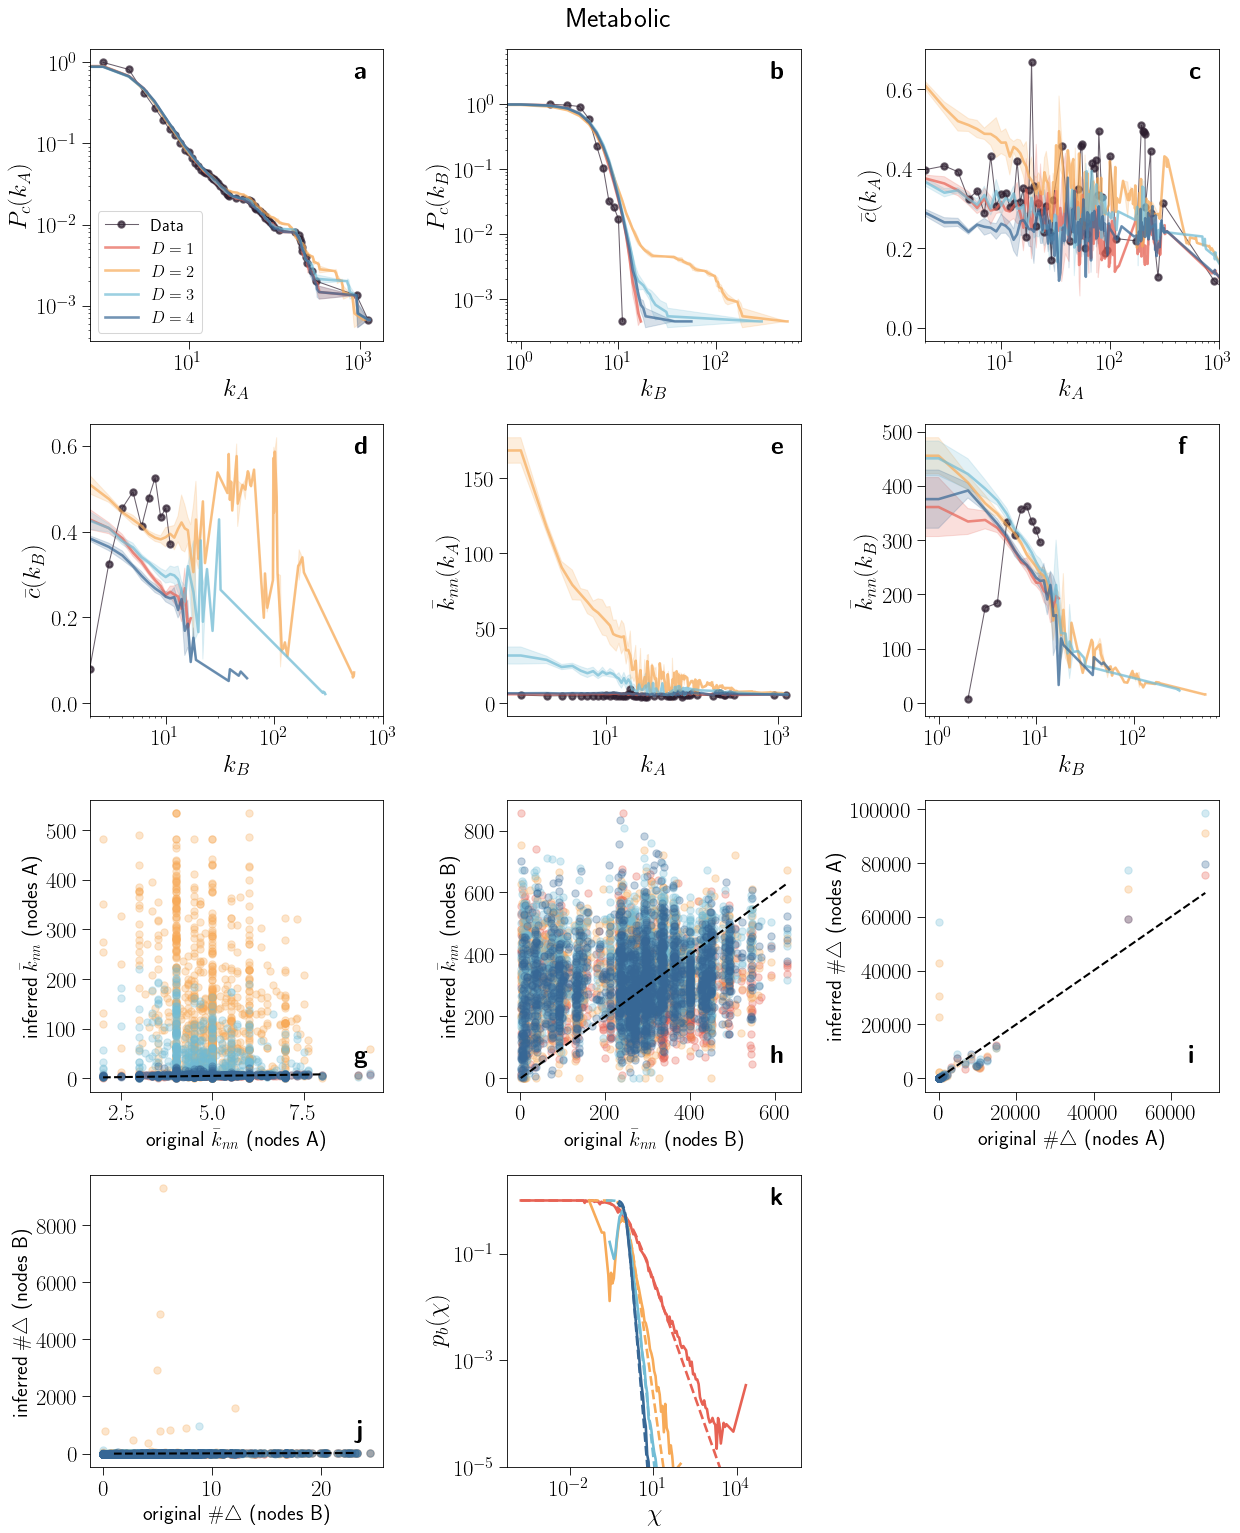

In [606]:
# base_path = "/home/rob/MEGAsync/datasets/networks/bipartite_networks/human_metabolic/Human/HumanbipartUU_noex-tr/"
# filename = 'HumanbipartUU_noex-tr'

base_path = "/home/rob/MEGAsync/datasets/networks/bipartite_networks/human_metabolic/Human/HumanbipartUU_noex-tr-reverted/"
filename = 'HumanbipartUU_noex-tr-reverted'


paths = [f"{base_path}/eS{d}" for d in [1, 2, 3, 4]]
labels = [rf'$D={d}$' for d in [1, 2, 3, 4]]


# Bipartite
dfs_vstats_bipartite_nodes = [load_vstats_bipartite_nodes(p, filename) for p in paths]
dfs_vstats_bipartite_features = [load_vstats_bipartite_features(p, filename) for p in paths]

df_vprop_bipartite_nodes = [load_vprops_bipartite_nodes(p, filename) for p in paths]
df_vprop_bipartite_features = [load_vprops_bipartite_features(p, filename) for p in paths]

df_obs_bipartite_nodes = load_vstat_obs_bipartite_nodes(paths[0], filename)
df_obs_bipartite_features = load_vstat_obs_bipartite_features(paths[0], filename)
df_pconns_bipartite = [load_bipartite_pcon(p, filename) for p in paths]

#########################
plt.figure(figsize=(17, 21))
plt.subplot(4, 3, 1)
plot_degree_distribution(df_obs_bipartite_nodes, dfs_vstats_bipartite_nodes, labels, xlabel=r'$k_A$',
                         ylabel=r'$P_c(k_A)$')
plt.legend(loc='lower left', fontsize=16)
plt.text(0.9, 0.9, r'$\textbf{a}$', fontsize=24, transform=plt.gca().transAxes)

plt.subplot(4, 3, 2)
plot_degree_distribution(df_obs_bipartite_features, dfs_vstats_bipartite_features, labels, xlabel=r'$k_B$',
                         ylabel=r'$P_c(k_B)$')
plt.text(0.9, 0.9, r'$\textbf{b}$', fontsize=24, transform=plt.gca().transAxes)

plt.subplot(4, 3, 3)
plot_clustering_coefficient(df_obs_bipartite_nodes, dfs_vstats_bipartite_nodes, labels, xlabel=r'$k_A$',
                         ylabel=r'$\bar{c}(k_A)$')
plt.xlim(2, 1000)
plt.text(0.9, 0.9, r'$\textbf{c}$', fontsize=24, transform=plt.gca().transAxes)

plt.subplot(4, 3, 4)
plot_clustering_coefficient(df_obs_bipartite_features, dfs_vstats_bipartite_features, labels, xlabel=r'$k_B$',
                         ylabel=r'$\bar{c}(k_B)$')
plt.xlim(2, 1000)
plt.text(0.9, 0.9, r'$\textbf{d}$', fontsize=24, transform=plt.gca().transAxes)

plt.subplot(4, 3, 5)
plot_average_degree_neighbour(df_obs_bipartite_nodes, dfs_vstats_bipartite_nodes, labels,
                              xlabel=r'$k_A$', ylabel=r"$\bar{k}_{nn}(k_A)$")
plt.text(0.9, 0.9, r'$\textbf{e}$', fontsize=24, transform=plt.gca().transAxes)

plt.subplot(4, 3, 6)
plot_average_degree_neighbour(df_obs_bipartite_features, dfs_vstats_bipartite_features, labels,
                              xlabel=r'$k_B$', ylabel=r"$\bar{k}_{nn}(k_B)$")
plt.text(0.86, 0.9, r'$\textbf{f}$', fontsize=24, transform=plt.gca().transAxes)

plt.subplot(4, 3, 7)
plot_sum_degree_neighbours(df_vprop_bipartite_nodes, labels, additional_label=' (nodes A)', 
                           log_scale=False)
plt.text(0.9, 0.1, r'$\textbf{g}$', fontsize=24, transform=plt.gca().transAxes)

plt.subplot(4, 3, 8)
plot_sum_degree_neighbours(df_vprop_bipartite_features, labels, additional_label=' (nodes B)',
                           log_scale=False)
plt.text(0.9, 0.1, r'$\textbf{h}$', fontsize=24, transform=plt.gca().transAxes)

plt.subplot(4, 3, 9)
plot_number_of_triangles(df_vprop_bipartite_nodes, labels, additional_label=' (nodes A)', 
                         log_scale=False)
plt.text(0.9, 0.1, r'$\textbf{i}$', fontsize=24, transform=plt.gca().transAxes)

plt.subplot(4, 3, 10)
plot_number_of_triangles(df_vprop_bipartite_features, labels, additional_label=' (nodes B)', 
                         log_scale=False)
plt.text(0.9, 0.1, r'$\textbf{j}$', fontsize=24, transform=plt.gca().transAxes)

plt.subplot(4, 3, 11)
plot_connection_probabilities(df_pconns_bipartite, labels, ylabel=r'$p_b(\chi)$')
plt.text(0.9, 0.9, r'$\textbf{k}$', fontsize=24, transform=plt.gca().transAxes)

plt.suptitle(r'Metabolic', y=0.98)
plt.tight_layout()

# plt.savefig("/home/rob/Dropbox/Robert/FeatureMercator/Paper/SI/plots/metabolic_validation.pdf")


In [293]:
# p = "/home/rob/MEGAsync/datasets/networks/bipartite_networks/human_metabolic/Human/HumanbipartUU_noex-tr/"

# df_nodes_S1, df_features_S1 = read_all_coordinates(1, f"{p}/eS1")
# df_nodes_S2, df_features_S2 = read_all_coordinates(2, f"{p}/eS2")
# df_nodes_S3, df_features_S3 = read_all_coordinates(3, f"{p}/eS3")
# df_nodes_S4, df_features_S4 = read_all_coordinates(4, f"{p}/eS4")

p = "/home/rob/MEGAsync/datasets/networks/bipartite_networks/human_metabolic/Human/HumanbipartUU_noex-tr-reverted/"

df_features_S1, df_nodes_S1 = read_all_coordinates(1, f"{p}/eS1")
df_features_S2, df_nodes_S2 = read_all_coordinates(2, f"{p}/eS2")
df_features_S3, df_nodes_S3 = read_all_coordinates(3, f"{p}/eS3")
df_features_S4, df_nodes_S4 = read_all_coordinates(4, f"{p}/eS4")


df_nodes_S1['x'] = df_nodes_S1['inf_radius'] * np.cos(df_nodes_S1['inf_theta'])
df_nodes_S1['y'] = df_nodes_S1['inf_radius'] * np.sin(df_nodes_S1['inf_theta']) 


In [608]:
df_features_S1.shape, df_nodes_S1.shape

((1497, 10), (2212, 30))

In [294]:
df_reaction = pd.read_csv("/home/rob/MEGAsync/datasets/networks/bipartite_networks/human_metabolic/Human/reactionpathway.tex", sep="\t", header=None)
df_reaction.columns = ['index', 'class2', 'class_num']

reaction_classes_dict = {
    1: 'Carbohydrate Metabolism',
    2: 'Carbohydrate Metabolism',
    3: 'Lipid Metabolism',
    4: 'Nucleotide Metabolism',
    5: 'Nucleotide Metabolism',
    6: 'Metabolism of Other Amino Acids',
    7: 'Glycan Biosynthesis and Metabolism',
    8: 'Metabolism of Cofactors and Vitamins',
    9: 'Metabolism of Terpenoids and Polyketides',
    10: 'Biosynthesis of Other Secondary Metabolites',
    11: 'Xenobiotics Biodegradation and Metabolism',
    12: 'Transport',
    13: 'Miscellaneous',
    14: 'Others',
    15: 'No Pathway'
}

pathway_dict = {
    1: "Alanine and Aspartate",
    2: "Alkaloid B II",
    3: "Aminosugar",
    4: "Arginine and Proline",
    5: "Ascorbate and Aldarate",
    6: "beta-Alanine",
    7: "Bile Acid B",
    8: "Biotin",
    9: "Blood Group B",
    10: "Butanoate",
    11: "C5-Branched dibasic acid",
    12: "Carnitine shuttle",
    13: "Cholesterol",
    14: "Chondroitin / heparan sulfate B",
    15: "Chondroitin sulfate D",
    16: "Citric Acid Cycle",
    17: "CoA B",
    18: "CoA Catabolism",
    19: "CYP",
    20: "Cysteine",
    21: "D-alanine",
    22: "D-arg and D-orn",
    23: "Eicosanoid",
    24: "Fatty acid activation",
    25: "Fatty acid elongation",
    26: "Fatty Acid",
    27: "Fatty acid oxidation",
    28: "Fatty acid oxidation, peroxisome",
    29: "Folate",
    30: "Fructose and Mannose",
    31: "Galactose",
    32: "Glutamate",
    33: "Glutathione",
    34: "Glycerophospholipid",
    35: "Glycine, Serine, and Threonine",
    36: "Glycolysis/Gluconeogenesis",
    37: "Glycosylphosphatidylinositol (GPI)-anchor B",
    38: "Glyoxylate and Dicarboxylate",
    39: "Heme B",
    40: "Heme D",
    41: "Heparan sulfate D",
    42: "Histidine",
    43: "Hyaluronan",
    44: "IMP B",
    45: "Inositol Phosphate",
    46: "Keratan sulfate B",
    47: "Keratan sulfate D",
    48: "Limonene and pinene D",
    49: "Lysine",
    50: "Methionine",
    51: "Miscellaneous",
    52: "N-Glycan B",
    53: "N-Glycan D",
    54: "NAD",
    55: "Nucleic acid D",
    56: "Nucleotide Sugar",
    57: "Nucleotides",
    58: "O-Glycan B",
    59: "Others",
    60: "Oxidative Phosphorylation",
    61: "Pentose and Glucuronate Interconversions",
    62: "Pentose Phosphate",
    63: "Phenylalanine",
    64: "Propanoate",
    65: "Purine C",
    66: "Pyrimidine B",
    67: "Pyrimidine C",
    68: "Pyruvate",
    69: "R Group B",
    70: "Riboflavin",
    71: "ROS Detoxification",
    72: "Salvage Pathway (Nucleotides)",
    73: "Selenoamino acid",
    74: "Sphingolipid",
    75: "Starch and Sucrose",
    76: "Steroid",
    77: "Stilbene, coumarine and lignin B",
    78: "Taurine and hypotaurine",
    79: "Tetrahydrobiopterin",
    80: "Thiamine",
    81: "Transport, Endoplasmic Reticular",
    82: "Transport, Extracellular",
    83: "Transport, Golgi Apparatus",
    84: "Transport, Lysosomal",
    85: "Transport, Mitochondrial",
    86: "Transport, Nuclear",
    87: "Transport, Peroxisomal",
    88: "Triacylglycerol B",
    89: "Tryptophan",
    90: "Tyr, Phe, Trp B",
    91: "Tyrosine",
    92: "Ubiquinone B",
    93: "Urea cycle/amino group",
    94: "Valine, Leucine, and Isoleucine",
    95: "Vitamin A",
    96: "Vitamin B12",
    97: "Vitamin B6",
    98: "Vitamin D",
    99: "No Pathway",
}


df_reaction['class'] = df_reaction['class_num'].apply(lambda x: reaction_classes_dict[x])
# df_reaction['class'] = df_reaction['class2'].apply(lambda x: pathway_dict[x])
df_reaction

,index,class2,class_num,class
0,10001,36,1,Carbohydrate Metabolism
1,10002,36,1,Carbohydrate Metabolism
2,10003,36,1,Carbohydrate Metabolism
3,10004,36,1,Carbohydrate Metabolism
4,10005,36,1,Carbohydrate Metabolism
...,...,...,...,...
3738,13739,81,12,Transport
3739,13740,81,12,Transport
3740,13741,99,15,No Pathway
3741,13742,99,15,No Pathway


In [295]:
df_reaction.groupby('class').count()

,index,class2,class_num
class,,,
Biosynthesis of Other Secondary Metabolites,30,30,30
Carbohydrate Metabolism,316,316,316
Glycan Biosynthesis and Metabolism,476,476,476
Lipid Metabolism,569,569,569
Metabolism of Cofactors and Vitamins,177,177,177
Metabolism of Other Amino Acids,71,71,71
Miscellaneous,13,13,13
No Pathway,432,432,432
Nucleotide Metabolism,564,564,564


In [296]:
df_nodes_S1 = pd.merge(df_nodes_S1, df_reaction, on='index')
df_nodes_S2 = pd.merge(df_nodes_S2, df_reaction, on='index')
df_nodes_S3 = pd.merge(df_nodes_S3, df_reaction, on='index')
df_nodes_S4 = pd.merge(df_nodes_S4, df_reaction, on='index')

In [297]:
df_nodes_S1.head()

,index,inf_kappa,inf_theta,inf_radius,inf_kappa_le,inf_theta_le,inf_radius_le,x,y,class2,class_num,class
0,10001,4.39200,2.84842,16.5494,3.16983,2.26388,17.2017,-15.843267,4.782627,36,1,Carbohydrate Metabolism
1,10002,5.59961,3.61118,16.0636,3.16983,3.42280,17.2017,-14.324797,-7.269074,36,1,Carbohydrate Metabolism
2,10003,8.02622,2.14665,15.3436,5.65544,1.74407,16.0438,-8.355373,12.869103,36,1,Carbohydrate Metabolism
3,10004,3.78050,2.69589,16.8493,4.38191,2.71268,16.5540,-15.203258,7.263598,36,1,Carbohydrate Metabolism
4,10005,10.77050,3.07001,14.7554,6.98449,3.44269,15.6216,-14.717612,1.055329,36,1,Carbohydrate Metabolism


In [298]:
# df_lang = pd.read_csv("/home/rob/MEGAsync/datasets/networks/bipartite_networks/unicodelang/language_scripts_cleaned.csv")

# df_features_S1 = pd.merge(df_features_S1, df_lang, left_on='index', right_on='Language Type')
# df_features_S2 = pd.merge(df_features_S2, df_lang, left_on='index', right_on='Language Type')
# df_features_S3 = pd.merge(df_features_S3, df_lang, left_on='index', right_on='Language Type')
# df_features_S4 = pd.merge(df_features_S4, df_lang, left_on='index', right_on='Language Type')


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


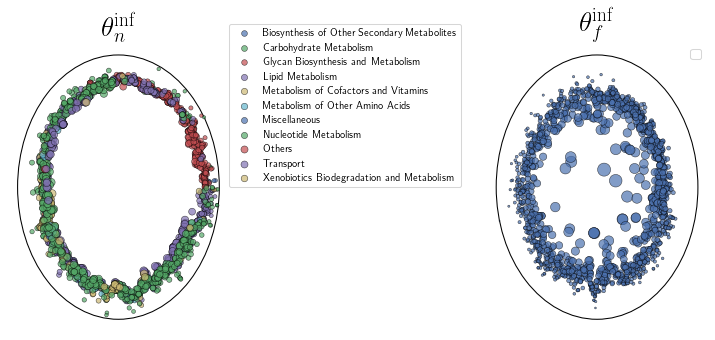

In [299]:
from matplotlib.patches import Circle

fig, axs = plt.subplots(1, 2, figsize=(10, 5))

for name, group in df_nodes_S1.groupby("class"):
    group['x'] = group['inf_radius'] * np.cos(group['inf_theta'])
    group['y'] = group['inf_radius'] * np.sin(group['inf_theta'])    
    axs[0].scatter(group['x'], group['y'], s=20*np.log(group['inf_kappa'] + 1), 
                   edgecolors='black', alpha=0.7, linewidths=0.5, zorder=2, label=name)

max_radius = df_nodes_S1['inf_radius'].max()
circle = Circle((0, 0), max_radius, color='black', fill=False, linestyle='-', linewidth=1)
axs[0].add_patch(circle)

axs[0].legend(fontsize=10, loc=(1, 0.5))

# for name, group in df_features_S1.groupby("Scripts"):
#     if len(group) > 10:
df_features_S1['x'] = df_features_S1['inf_radius'] * np.cos(df_features_S1['inf_theta'])
df_features_S1['y'] = df_features_S1['inf_radius'] * np.sin(df_features_S1['inf_theta']) 
axs[1].scatter(df_features_S1['x'], df_features_S1['y'], s=20*np.log(df_features_S1['inf_kappa'] + 1),
               edgecolors='black', alpha=0.7, linewidths=0.5, zorder=2)

max_radius = df_features_S1['inf_radius'].max()
circle = Circle((0, 0), max_radius, color='black', fill=False, linestyle='-', linewidth=1)
axs[1].add_patch(circle)

axs[1].legend(fontsize=13)

axs[0].set_title(r'$\theta_n^{\mathrm{inf}}$')
axs[1].set_title(r'$\theta_f^{\mathrm{inf}}$')
axs[0].axis('off')
axs[1].axis('off')

plt.tight_layout()

# plt.savefig("/home/rob/Dropbox/Robert/FeatureMercator/Reports/unicodelang-dataset-13-11-24/plots/unicodelang_S1_viz.pdf")


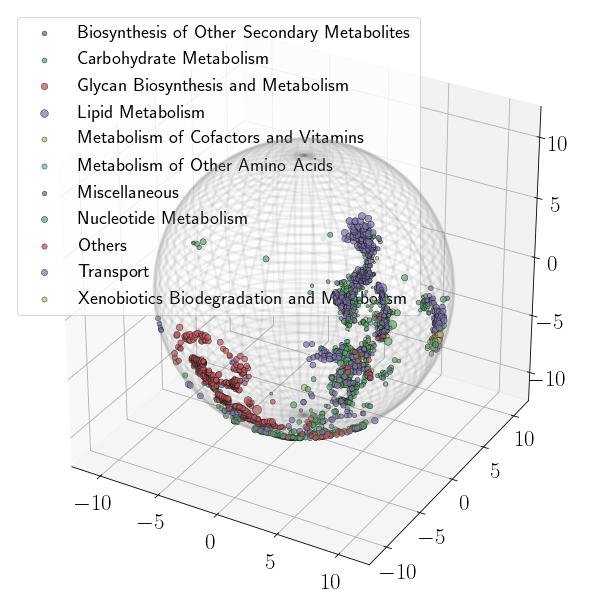

In [300]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')

for name, group in df_nodes_S2.groupby("class"):
    ax.scatter(group['inf_p0'], group['inf_p1'], group['inf_p2'], 
               s=20*np.log(group['inf_kappa'] + 1), label=name,
               edgecolors='black', alpha=0.7, linewidths=0.5, zorder=2)
      
ax.legend()
radius = np.linalg.norm(df_nodes_S2[['inf_p0', 'inf_p1', 'inf_p2']].values[0])
u = np.linspace(0, 2 * np.pi, 100)
v = np.linspace(0, np.pi, 100)
x = radius * np.outer(np.cos(u), np.sin(v))
y = radius * np.outer(np.sin(u), np.sin(v))
z = radius * np.outer(np.ones(np.size(u)), np.cos(v))
ax.plot_wireframe(x, y, z, color='grey', alpha=0.1, zorder=0)
ax.set_box_aspect([1, 1, 1])


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


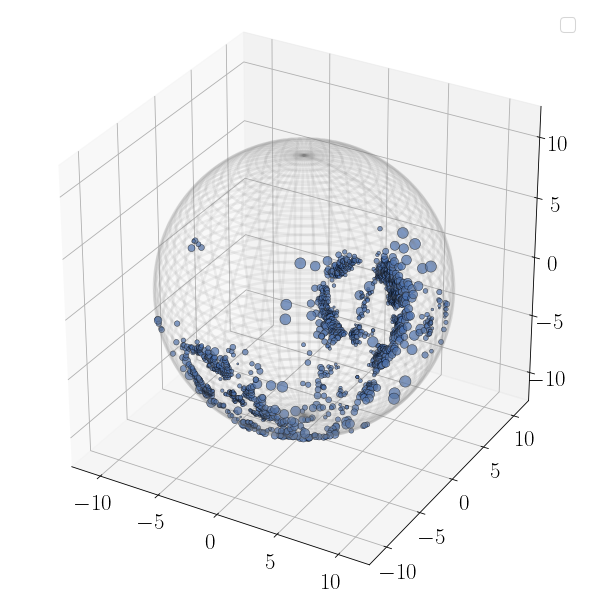

In [301]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')

# for name, group in df_features_S2.groupby("Scripts"):
#     if len(group) > 10:
ax.scatter(df_features_S2['inf_p0'], df_features_S2['inf_p1'], df_features_S2['inf_p2'], 
           s=20*np.log(df_features_S2['inf_kappa'] + 1),
           edgecolors='black', alpha=0.7, linewidths=0.5, zorder=2, marker='o')

ax.legend()
radius = np.linalg.norm(df_nodes_S2[['inf_p0', 'inf_p1', 'inf_p2']].values[0])
u = np.linspace(0, 2 * np.pi, 100)
v = np.linspace(0, np.pi, 100)
x = radius * np.outer(np.cos(u), np.sin(v))
y = radius * np.outer(np.sin(u), np.sin(v))
z = radius * np.outer(np.ones(np.size(u)), np.cos(v))
ax.plot_wireframe(x, y, z, color='grey', alpha=0.1, zorder=0)
ax.set_box_aspect([1, 1, 1])


In [302]:
df_metabolites = pd.read_csv("/home/rob/MEGAsync/datasets/networks/bipartite_networks/human_metabolic/Human/metaboliteList.tex", 
                             sep="\t", header=None)
df_metabolites.columns = ['index', 'name']

df_features_S1 = df_features_S1.merge(df_metabolites)
df_features_S2 = df_features_S2.merge(df_metabolites)

In [303]:
df_reactions_names = pd.read_excel("/home/rob/MEGAsync/datasets/networks/bipartite_networks/human_metabolic/Human/reactionList_names.xls")

df_nodes_S1 = df_nodes_S1.merge(df_reactions_names, left_on='index', right_on='id')
df_nodes_S2 = df_nodes_S2.merge(df_reactions_names, left_on='index', right_on='id')

In [304]:
from networkx.algorithms import bipartite

g = bipartite.read_edgelist("/home/rob/MEGAsync/datasets/networks/bipartite_networks/human_metabolic/Human/HumanbipartUU_noex-tr-reverted/HumanbipartUU_noex-tr-reverted.edge",
                    nodetype=int)
print(g)

Graph with 3709 nodes and 10821 edges


In [305]:
print(df_nodes_S1.columns)

Index(['index', 'inf_kappa', 'inf_theta', 'inf_radius', 'inf_kappa_le',
       'inf_theta_le', 'inf_radius_le', 'x', 'y', 'class2', 'class_num',
       'class', 'id', 'abbreviation', 'name', 'synonyms', 'type', 'Included',
       'equation', 'subsystem', 'compartment', 'ecnumber', 'reversible',
       'translocation', 'internal_id', 'confidence_score', 'notes',
       'Unnamed: 15', 'Unnamed: 16', 'Unnamed: 17'],
      dtype='object')


In [361]:
np.unique(df_nodes_S1['class'], return_counts=True)

(array(['Biosynthesis of Other Secondary Metabolites',
        'Carbohydrate Metabolism', 'Glycan Biosynthesis and Metabolism',
        'Lipid Metabolism', 'Metabolism of Cofactors and Vitamins',
        'Metabolism of Other Amino Acids', 'Miscellaneous',
        'Nucleotide Metabolism', 'Others', 'Transport',
        'Xenobiotics Biodegradation and Metabolism'], dtype=object),
 array([ 30, 316, 458, 533, 175,  63,  13, 561,   2,  46,  15]))

In [459]:
import glasbey

# colors = glasbey.create_palette(palette_size=12)

colors = [
    "#332288",  # Dark Blue
    "#117733",  # Green
    "#88CCEE",  # Sky Blue
    "#44AA99",  # Teal
    "#DDCC77",  # Mustard Yellow
    "#CC6677",  # Muted Red
    "#882255",  # Burgundy
    "#AA4499",  # Magenta
    "#999933",  # Olive
    "#661100",  # Brown
    "#808080"   # Grey
]

#['#543005','#8c510a','#bf812d','#dfc27d','#f6e8c3',
 #         '#c7eae5','#80cdc1','#35978f','#01665e','#003c30']

unique_names, unique_count = np.unique(df_nodes_S1['class'], return_counts=True)

colors_map = dict(zip(unique_names, colors))
colors_map


{'Biosynthesis of Other Secondary Metabolites': '#332288',
 'Carbohydrate Metabolism': '#117733',
 'Glycan Biosynthesis and Metabolism': '#88CCEE',
 'Lipid Metabolism': '#44AA99',
 'Metabolism of Cofactors and Vitamins': '#DDCC77',
 'Metabolism of Other Amino Acids': '#CC6677',
 'Miscellaneous': '#882255',
 'Nucleotide Metabolism': '#AA4499',
 'Others': '#999933',
 'Transport': '#661100',
 'Xenobiotics Biodegradation and Metabolism': '#808080'}

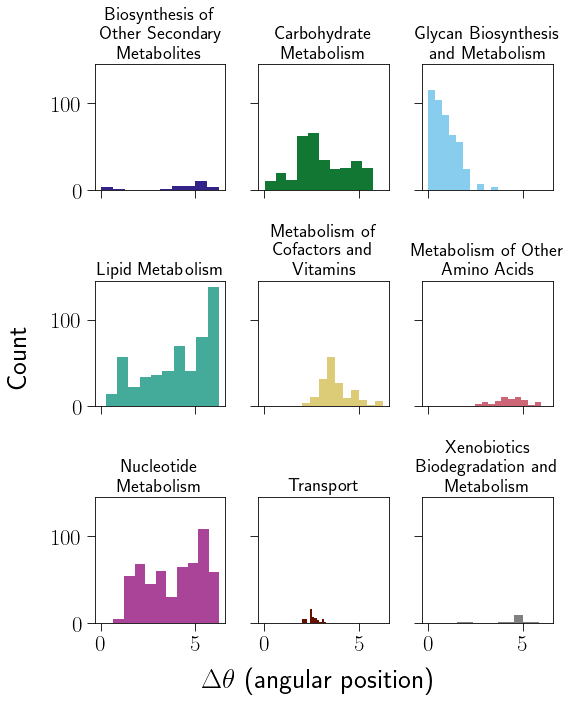

In [603]:
import textwrap

fig, axs = plt.subplots(3, 3, figsize=(8, 10), sharey=True, sharex=True)
ax = axs.flatten()
i = 0

for name, group in df_nodes_S1.groupby('class'):
    if len(group) >= 15: 
        ax[i].hist(group['inf_theta'], color=colors_map[name])
        title = "\n".join(textwrap.wrap(name, width=20))
        ax[i].set_title(title, fontsize=18)
        i += 1
        
fig.supxlabel(r'$\Delta\theta$ (angular position)', x=0.57, y=0.05)
fig.supylabel(r'Count', x=0.05)

plt.tight_layout()

# plt.savefig("/home/rob/Dropbox/Robert/FeatureMercator/Paper/SI/plots/metabolic_angular_distr_by_type.pdf")

In [509]:
import matplotlib.pyplot as plt
from matplotlib.patches import Circle
import numpy as np

def plot_compound_neighbors(index, compound_name, g, df_nodes_S1, df_features_S1):
    # Look up the compound by its name (note: using column 'name' instead of 'compound_name')
    compound_row = df_features_S1[df_features_S1['name'] == compound_name]
    if compound_row.empty:
        print(f"Compound '{compound_name}' not found in df_features_S1.")
        return

    # Get the compound's x and y coordinates
    compound_x = compound_row['x'].values[0]
    compound_y = compound_row['y'].values[0]

    # Prepare lists to store neighbor properties
    pos_x, pos_y = [], []
    abbreviations = []
    neighbor_classes = []
    sizes = []

    # Loop over all neighbors of the chosen node (by index) in the graph
    for neighbor in list(g.neighbors(index)):
        tmp = df_nodes_S1[df_nodes_S1['index'] == neighbor]
        if tmp.empty:
            continue

        # Calculate the position in polar coordinates
        r = tmp['inf_radius'].values[0]
        theta = tmp['inf_theta'].values[0]
        x_val = r * np.cos(theta)
        y_val = r * np.sin(theta)
        pos_x.append(x_val)
        pos_y.append(y_val)

        # Get the abbreviation and class for labeling and coloring
        abbreviation = tmp['abbreviation'].values[0]
        node_class = tmp['class'].values[0]
        abbreviations.append(abbreviation)
        neighbor_classes.append(node_class)

        # Use the degree of the neighbor from the graph to determine its marker size
        sizes.append(g.degree(neighbor))

    sizes = np.array(sizes)
    # Optionally, scale sizes for better visibility (adjust the factor as needed)
    marker_sizes = sizes * 40

    # Map each neighbor's class to its corresponding color
    colors = [colors_map[cls] for cls in neighbor_classes]

    fig, ax = plt.subplots(figsize=(12, 12))

    # Plot the neighbor nodes
    ax.scatter(pos_x, pos_y, c=colors, s=marker_sizes, edgecolors='black',
               alpha=0.7, linewidths=0.5, zorder=2)

    # Add text labels using the abbreviation for each neighbor
    random.seed(33)
    random_subset = random.sample(range(len(pos_x)), 15) # pick random nodes to plot labels 
    for i in random_subset:
        ax.text(pos_x[i], pos_y[i], abbreviations[i], fontsize=18, zorder=3)
            
    
#     for x, y, abbr,s  in zip(pos_x, pos_y, abbreviations, sizes):
#         if s > 4:
#             ax.text(x, y, abbr, fontsize=10, zorder=3)

    # Plot the central compound node as a star marker
    ax.scatter(compound_x, compound_y, s=500, color='grey', marker='*',
               edgecolors='black', zorder=5)
    ax.text(compound_x, compound_y, compound_name,
            color='xkcd:black', bbox=dict(facecolor='none', edgecolor='black', boxstyle='round'),
            zorder=10, fontsize=26)

    # Draw a circle representing the maximum radius found in df_nodes_S1
    max_radius = df_nodes_S1['inf_radius'].max()
    circle = Circle((0, 0), max_radius, color='black', fill=False, linestyle='-', linewidth=1)
    ax.add_patch(circle)

    legend_handles = [
        plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=colors_map[cls],
                   markersize=10, linestyle='None')
        for cls in unique_names
    ]
    legend_labels = list(unique_names)
    ax.legend(legend_handles, legend_labels, loc=(1, 0.6), framealpha=1)

    ax.axis('off')
    ax.set_box_aspect(1)
    plt.tight_layout()


In [510]:
df_features_S1.sort_values('inf_kappa')[::-1].head(30)

,index,inf_kappa,inf_theta,inf_radius,inf_kappa_le,inf_theta_le,inf_radius_le,x,y,name
60,61,2607.3200,1.085310,3.77686,2650.3000,2.245490,2.35787,1.762428,3.340437,h
0,1,1544.8700,0.256274,4.82363,1530.3100,2.006250,3.45627,4.666096,1.222684,h2o
9,10,357.9630,6.049180,7.74816,317.8940,4.465800,6.59928,7.536988,-1.796609,coa
1,2,304.5040,2.498680,8.07165,361.4720,2.640030,6.34235,-6.460169,4.839189,atp
13,14,231.6340,0.995490,8.61870,188.2390,1.414450,7.64730,4.689364,7.231311,udp
8,9,225.0770,2.720110,8.67613,269.2500,2.581270,6.93144,-7.916824,3.549525,pi
7,8,218.0080,2.425340,8.73995,265.3880,2.501520,6.96034,-6.592294,5.738326,adp
6,7,213.3370,4.623300,8.78327,233.6640,4.478400,7.21496,-0.781458,-8.748437,o2
5,6,211.7290,4.621570,8.79841,231.1610,3.785860,7.23649,-0.797965,-8.762150,nadp
2,3,210.6740,5.516390,8.80840,221.2070,4.365070,7.32452,6.343262,-6.111541,nad


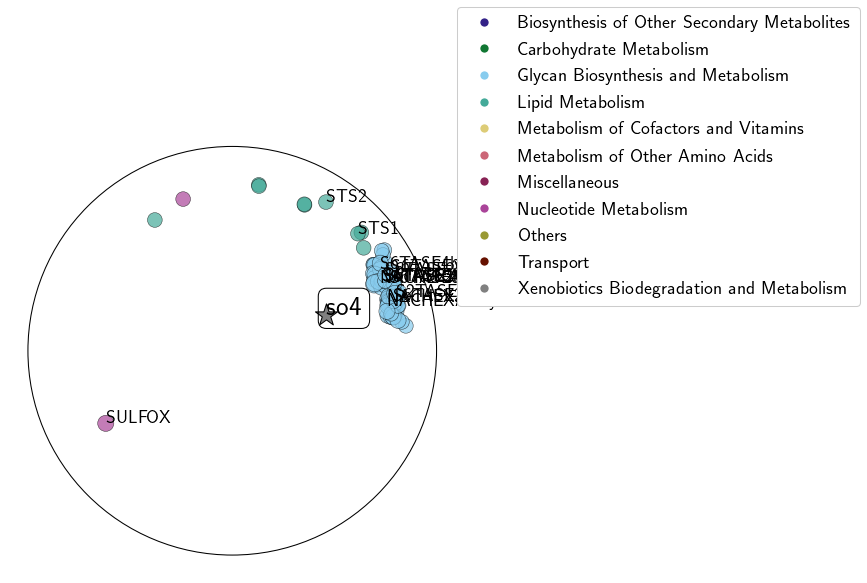

In [511]:
plot_compound_neighbors(46, "so4", g, df_nodes_S1, df_features_S1)

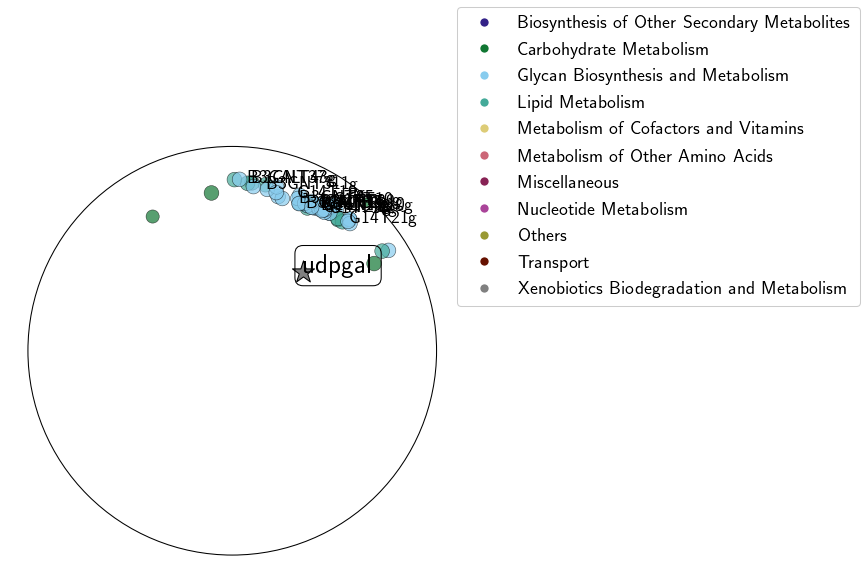

In [512]:
plot_compound_neighbors(41, "udpgal", g, df_nodes_S1, df_features_S1)

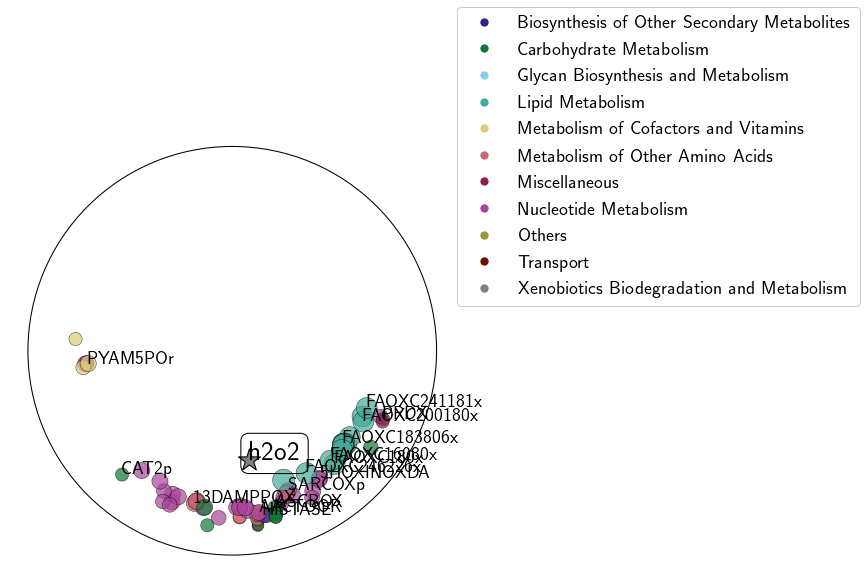

In [525]:
plot_compound_neighbors(25, "h2o2", g, df_nodes_S1, df_features_S1)
# plt.savefig("/home/rob/Dropbox/Robert/FeatureMercator/Paper/plots/metabolic/h2o2_dim1.pdf")

In [539]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np

def plot_spherical_cap(ax, b, opening_angle, R, radius=1.0, color='grey'):
    """Plot a spherical cap at a given position on the unit sphere."""
    r = R
    phi = np.linspace(0, 2 * np.pi, 40)
    theta = np.linspace(0, opening_angle, 40)
    X = r * np.stack([
        np.outer(np.cos(phi), np.sin(theta)),
        np.outer(np.sin(phi), np.sin(theta)),
        np.outer(np.ones(np.size(phi)), np.cos(theta)),
    ], axis=-1)

    # Rotate X such that [0, 0, 1] gets rotated to `b`
    a = np.array([0.0, 0.0, 1.0])
    b = b / np.linalg.norm(b)  # Normalize b
    a_x_b = np.cross(a, b)
    a_dot_b = np.dot(a, b)
    if a_dot_b == -1.0:
        X_rot = -X
    else:
        X_rot = (
            X +
            np.cross(a_x_b, X) +
            np.cross(a_x_b, np.cross(a_x_b, X)) / (1.0 + a_dot_b)
        )

    ax.plot_surface(
        X_rot[..., 0], X_rot[..., 1], X_rot[..., 2],
        rstride=1, cstride=1,
        color=color,
        alpha=0.8,
        linewidth=0,
        zorder=200,
        shade=False, antialiased=False,
    )
    
    boundary_x = X_rot[:, -1, 0]
    boundary_y = X_rot[:, -1, 1]
    boundary_z = X_rot[:, -1, 2]
    
    # Draw a black border along the cap's boundary
    ax.plot(boundary_x, boundary_y, boundary_z, color='black', linewidth=0.5, zorder=300)


def plot_compound_ingredients_sphere(index, compound_name, g, df_nodes_S1, df_features_S1, max_degree=100):
    # Lists to store neighbor properties
    pos_x, pos_y, pos_z = [], [], []
    abbreviations = []  # Use 'abbreviation' for node labels
    colors = []         # Colors will be determined by the node's class
    sizes = []          # Use the graph degree to scale the cap opening angle

    # Look up the compound row using the 'name' column
    compound_row = df_features_S1[df_features_S1['name'] == compound_name]
    if compound_row.empty:
        print(f"Compound '{compound_name}' not found in df_features_S1.")
        return

    # Extract and normalize the compound's 3D coordinates
    compound_coords = np.array([
        compound_row['inf_p0'].values[0],
        compound_row['inf_p1'].values[0],
        compound_row['inf_p2'].values[0]
    ])
    compound_coords = compound_coords / np.linalg.norm(compound_coords)

    # Create a color mapping for each unique class in df_nodes_S1
    
    # Iterate over the neighbors of the compound (given by its index in the graph)
    for neighbor in list(g.neighbors(index)):
        tmp = df_nodes_S1[df_nodes_S1['index'] == neighbor]
        if tmp.empty:
            continue

        # Extract and normalize the neighbor's 3D coordinates
        coords = np.array([
            tmp['inf_p0'].values[0],
            tmp['inf_p1'].values[0],
            tmp['inf_p2'].values[0]
        ])
        coords = coords / np.linalg.norm(coords)
        pos_x.append(coords[0])
        pos_y.append(coords[1])
        pos_z.append(coords[2])
        
        # Use the 'abbreviation' column for labeling
        abbreviations.append(tmp['abbreviation'].values[0])
        # Determine the node's class and assign its corresponding color
        node_class = tmp['class'].values[0]
        colors.append(colors_map[node_class])
        # Use the degree from the graph to scale the cap's opening angle
        sizes.append(g.degree(neighbor))
    
    sizes = np.array(sizes)

    # Create a 3D plot
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(projection='3d')
    ax.set_box_aspect((1, 1, 1))
    plt.axis('off')

    # Plot a wireframe of the unit sphere
    N = 40
    u = np.linspace(0, 2 * np.pi, N)
    v = np.linspace(0, np.pi, N)
    sphere_x = np.outer(np.cos(u), np.sin(v))
    sphere_y = np.outer(np.sin(u), np.sin(v))
    sphere_z = np.outer(np.ones(np.size(u)), np.cos(v))
    ax.plot_wireframe(sphere_x, sphere_y, sphere_z, color='black', linewidth=0.5, alpha=0.1)

    # Annotate neighbors that have a high degree (i.e. above max_degree) using their abbreviation
#     for (x, y, z, abbr, s) in zip(pos_x, pos_y, pos_z, abbreviations, sizes):
#         if s > max_degree:
#             ax.text(x, y, z, abbr, fontsize=16, zorder=100)
    
    random.seed(129)#33
    random_subset = random.sample(range(len(pos_x)), 15) # pick random nodes to plot labels 
    for i in random_subset:
        ax.text(pos_x[i], pos_y[i], pos_z[i], abbreviations[i], fontsize=18, zorder=3)
    
    
    R = 1.0  # Sphere radius
    # For each neighbor, plot a spherical cap whose opening angle is scaled by its degree
    for x, y, z, s, c in zip(pos_x, pos_y, pos_z, sizes, colors):
        cap_ratio = s / max(sizes) if max(sizes) > 0 else 0
        opening_angle = cap_ratio * 0.05  # Adjust this factor as needed
        plot_spherical_cap(ax, np.array([x, y, z]), opening_angle=opening_angle, R=R + 0.01, color=c)

    # Plot the compound as a star marker and label it
    ax.scatter(compound_coords[0], compound_coords[1], compound_coords[2], s=500,
               color='grey', marker='*', edgecolors='black', zorder=5)
    ax.text(compound_coords[0], compound_coords[1], compound_coords[2], compound_name,
            color='xkcd:black', bbox=dict(facecolor='none', edgecolor='black', boxstyle='round'), zorder=10,
           fontsize=26)

    plt.tight_layout()


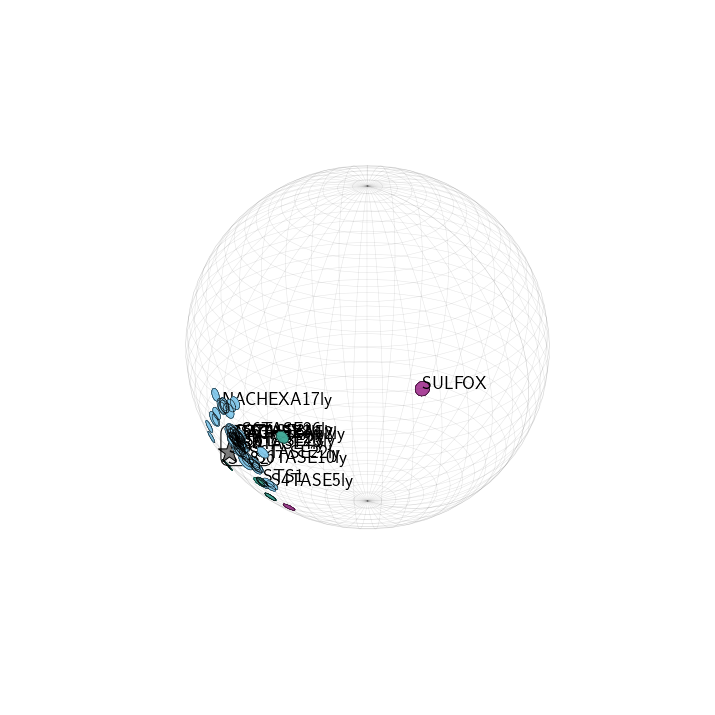

In [534]:
plot_compound_ingredients_sphere(46, "so4", g, df_nodes_S2, df_features_S2)

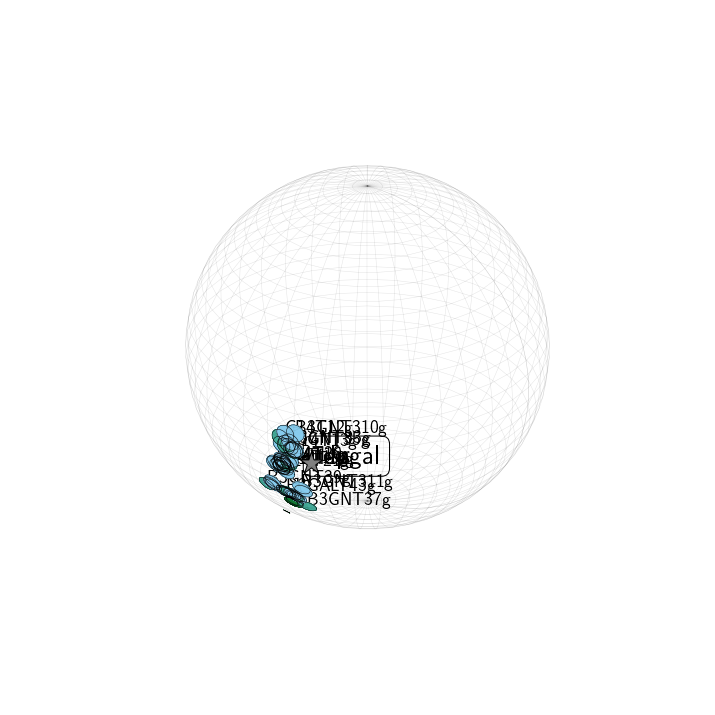

In [535]:
plot_compound_ingredients_sphere(41, "udpgal", g, df_nodes_S2, df_features_S2)

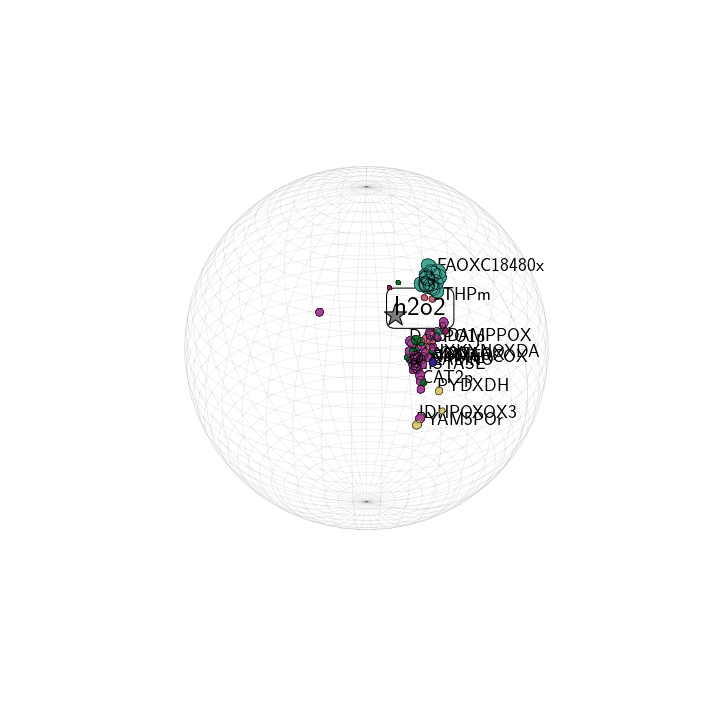

In [542]:
plot_compound_ingredients_sphere(25, "h2o2", g, df_nodes_S2, df_features_S2, max_degree=5)

# plt.savefig("/home/rob/Dropbox/Robert/FeatureMercator/Paper/plots/metabolic/h2o2_dim2.pdf")

In [548]:
df_nodes_S1[df_nodes_S1['abbreviation'] == '13DAMPPOX']

,index,inf_kappa,inf_theta,inf_radius,inf_kappa_le,inf_theta_le,inf_radius_le,x,y,class2,class_num,class,id,abbreviation,name,synonyms,type,Included,equation,subsystem,compartment,ecnumber,reversible,translocation,internal_id,confidence_score,notes,Unnamed: 15,Unnamed: 16,Unnamed: 17
993,11271,6.77125,4.46871,15.6836,6.98449,4.74079,15.6216,-3.784053,-15.220258,6,6,Metabolism of Other Amino Acids,11271,13DAMPPOX,"1,3-Diaminopropane:oxygen oxidoreductase (deam...",NaN,8,1,[c] : 13dampp + h2o + o2 --> bamppald + h2o2 +...,beta-Alanine metabolism,Cytosol,1.4.3.6,Irreversible,N,2228934,1.0,cytosolic because no good evidence to the cont...,NaN,NaN,NaN


---
---

In [589]:
def plot_ingredient_compounds(index, ingredient_name, g, df_nodes_S1, df_features_S1, max_degree=100):
    pos_x, pos_y, compounds, sizes = [], [], [], []
    
    # Look up the ingredient node in df_nodes_S1
    ingredient_row = df_nodes_S1[df_nodes_S1['abbreviation'] == ingredient_name]
    if ingredient_row.empty:
        print(f"Ingredient '{ingredient_name}' not found in df_nodes_S1.")
        return

    # Get the ingredient's coordinates (assumed to be in cartesian coordinates)
    ingredient_x = ingredient_row['x'].values[0]
    ingredient_y = ingredient_row['y'].values[0]

    # Iterate over all neighboring compounds of the given ingredient node
    for compound in list(g.neighbors(index)):
        tmp = df_features_S1[df_features_S1['index'] == compound]
        if tmp.empty:
            continue
        # Compute the compound's position using polar coordinates
        radius = tmp['inf_radius'].values[0]
        theta = tmp['inf_theta'].values[0]
        pos_x.append(radius * np.cos(theta))
        pos_y.append(radius * np.sin(theta))
        # Use the 'name' column for labeling the compound
        compounds.append(tmp['name'].values[0])
        sizes.append(g.degree(compound))
    
    sizes = np.array(sizes)
    
    # Create the plot
    fig, ax = plt.subplots(figsize=(8, 8))
    
    # Plot compounds with marker sizes scaled by their degree
    # Color the compounds using the ingredient's color (from df_nodes_S1)
    #ingredient_color = ingredient_row['color'].values[0] if 'color' in ingredient_row.columns else 'blue'
    ingredient_color = colors_map[ingredient_row['class'].values[0]]
    
    ax.scatter(pos_x, pos_y, color=ingredient_color, 
               s=3 * sizes, edgecolors='black', alpha=0.7, linewidths=0.5, zorder=2)
    
    # Annotate compounds with high degree
    for (x, y, comp, s) in zip(pos_x, pos_y, compounds, sizes):
        if s > max_degree:
            ax.text(x, y, comp, fontsize=28, zorder=3)
    
    # Plot the ingredient node as a star marker
    ax.scatter(ingredient_x, ingredient_y, s=500, color='grey', marker='*', edgecolors='black', zorder=5)
    ax.text(ingredient_x, ingredient_y, ingredient_name, 
            color='xkcd:black', bbox=dict(facecolor='none', edgecolor='black', boxstyle='round'), zorder=10,
           fontsize=30)
    
    max_radius = df_features_S1['inf_radius'].max()
    circle = Circle((0, 0), max_radius, color='black', fill=False, linestyle='-', linewidth=1)
    ax.add_patch(circle)
    
    ax.axis('off')
    ax.set_box_aspect(1)
    plt.tight_layout()

In [590]:
pd.options.display.max_columns = None

# df_nodes_S1.sort_values('inf_kappa')[::-1].head(20)
df_nodes_S1.sample(10)

,index,inf_kappa,inf_theta,inf_radius,inf_kappa_le,inf_theta_le,inf_radius_le,x,y,class2,class_num,class,id,abbreviation,name,synonyms,type,Included,equation,subsystem,compartment,ecnumber,reversible,translocation,internal_id,confidence_score,notes,Unnamed: 15,Unnamed: 16,Unnamed: 17
7,10008,5.99899,3.600350,15.9258,3.16983,3.684130,17.2017,-14.279128,-7.052490,68,1,Carbohydrate Metabolism,10008,MGSA,methylglyoxal synthase,NaN,8,1,[c] : dhap --> mthgxl + pi,Pyruvate Metabolism,Cytosol,4.2.3.3,Irreversible,N,134455,4.0,- methylglyoxylate can be produced from the no...,NaN,NaN,NaN
1152,11453,2.97887,0.744275,17.3259,5.65544,0.633431,16.0438,12.744572,11.737235,77,10,Biosynthesis of Other Secondary Metabolites,11453,BDG2HCGHD,beta-D-Glucosyl-2-coumarinate glucohydrolase,NaN,8,1,[c] : bdg2hc + h2o --> 2coum + glc-D + h,"Stilbene, coumarine and lignin biosynthesis",Cytosol,3.2.1.21,Irreversible,N,2266563,1.0,"Not certain, but seems reasonable////there is ...",NaN,NaN,NaN
1983,13003,10.69050,2.422840,14.7703,6.98449,2.153100,15.6216,-11.116536,9.725451,82,12,Transport,13003,PEFLIP,phosphatidylethanolamine flippase,NaN,21,1,atp[c] + h2o[c] + pe_hs[e] --> adp[c] + h[c] +...,"Transport, Extracellular","Cytosol, Extra-organism",NaN,Irreversible,Y,2429462,4.0,transport out of mitochondria - flip and flip ...,NaN,NaN,NaN
1133,11434,4.22355,5.216540,16.6277,4.38191,5.609990,16.5540,8.032248,-14.558963,49,5,Nucleotide Metabolism,11434,LYSMTF3n,"histone-lysine N-methyltransferase, nuclear","$N-methyltransferase, histone H1-specific S-ad...",14,1,[n] : Ndmelys + amet --> Ntmelys + ahcys,Lysine Metabolism,Nucleus,2.1.1.43,Irreversible,N,2265907,4.0,interacts w/ DNA as histone methyltransferase;...,NaN,NaN,NaN
1183,11484,5.18447,1.628210,16.2177,5.65544,1.258340,16.0438,-0.930606,16.190978,74,3,Lipid Metabolism,11484,ST6GALNAC24,"Alpha-N-acetylgalactosaminide alpha-2,6-sialyl...","GalNAc alpha-2,6-sialyltransferase II, SIAT7B,...",11,1,[g] : cmpacna + gm1a_hs --> cmp + gd1b2_hs + h,Sphingolipid Metabolism,Golgi Apparatus,NaN,Irreversible,N,2267302,2.0,Golgi - lumen side - see ref Kolter and Sanhof...,NaN,NaN,NaN
30,10031,8.65890,2.102900,15.1918,5.65544,1.741230,16.0438,-7.707518,13.091407,31,1,Carbohydrate Metabolism,10031,GALU,UTP-glucose-1-phosphate uridylyltransferase,NaN,8,1,[c] : g1p + h + utp <==> ppi + udpg,Galactose metabolism,Cytosol,2.7.7.9,Reversible,N,136602,0.0,"7359://- cytosolic [GO],[UniProt]",NaN,NaN,NaN
596,10852,1.63652,0.570940,18.5239,5.65544,0.570940,16.0438,15.585886,10.010745,58,7,Glycan Biosynthesis and Metabolism,10852,N4Tg,N-acetylgalactosamine 4-beta-galactosyltransfe...,glycoprotein-N-acetylgalactosamine 4-beta-gala...,11,1,[g] : core6 + udpgal --> f1a + h + udp,O-Glycan Biosynthesis,Golgi Apparatus,NaN,Irreversible,N,1886208,0.0,"enzyme functionality is known to exist, but ca...",NaN,NaN,NaN
343,10525,5.75871,4.275120,16.0076,5.65544,3.394400,16.0438,-6.778690,-14.501470,65,4,Nucleotide Metabolism,10525,GUAD,guanine deaminase,NaN,8,1,[c] : gua + h + h2o --> nh4 + xan,Purine Catabolism,Cytosol,3.5.4.3,Irreversible,N,1528512,4.0,homodimer //binds 1 zinc per subunit//IT,NaN,NaN,NaN
1311,11704,3.29474,0.995707,17.1244,5.65544,0.778297,16.0438,9.314128,14.369833,46,7,Glycan Biosynthesis and Metabolism,11704,AG13T3g,"N-acetyllactosaminide beta-1,3-N-acetylglucosa...",Galbeta1->4GlcNAc-R beta1->3 N-acetylglucosami...,11,1,[g] : ksii_core2_pre7 + uacgam --> h + ksii_co...,Keratan sulfate biosynthesis,Golgi Apparatus,2.4.1.149,Irreversible,N,2296765,4.0,"from [Ujita, J Biol Chem 2000]://- N-glycans: ...",NaN,NaN,NaN
1136,11437,1.73150,0.043045,18.4110,3.16983,0.053969,17.2017,18.393946,0.792257,48,10,Biosynthesis of Other Secondary Metabolites,11437,C2M26DCOAHLm,"cis-2-Methyl-5-isopropylhexa-2,5-dienoyl-CoA h...",NaN,13,1,[m] : c2m26dcoa + h2o <==> 3h26dm5coa,Limonene and pinene degradation,Mitochondria,4.2.1.17,Reversible,N,2266113,1.0,reaction from KEGG--gene associations highly u...,NaN,NaN,NaN


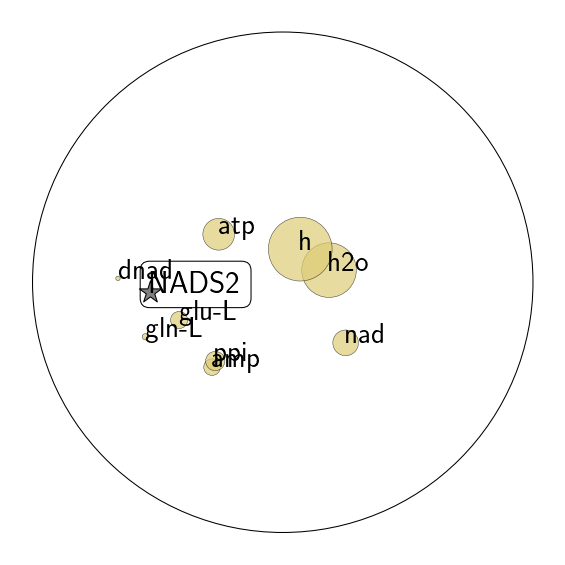

In [599]:
plot_ingredient_compounds(10148, "NADS2", g, df_nodes_S1, df_features_S1, max_degree=1)

# plt.savefig("/home/rob/Dropbox/Robert/FeatureMercator/Paper/plots/metabolic/NADS2_dim1.pdf")

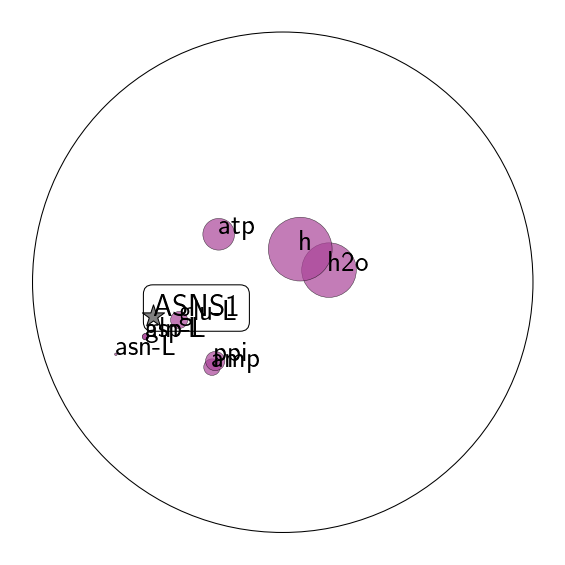

In [592]:
plot_ingredient_compounds(10044, "ASNS1", g, df_nodes_S1, df_features_S1, max_degree=1)

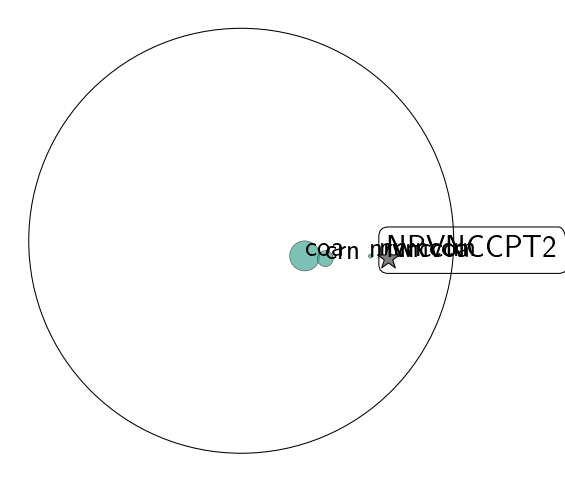

In [593]:
plot_ingredient_compounds(13184, "NRVNCCPT2", g, df_nodes_S1, df_features_S1, max_degree=1)

In [601]:
def plot_ingredient_compounds_sphere(index, ingredient_name, g, df_nodes_S2, df_features_S2, max_degree=100):
    pos_x, pos_y, pos_z = [], [], []
    compounds, kappas, sizes = [], [], []

    # Look up the ingredient node from df_nodes_S2
    ingredient_row = df_nodes_S2[df_nodes_S2['abbreviation'] == ingredient_name]
    if ingredient_row.empty:
        print(f"Ingredient '{ingredient_name}' not found in df_nodes_S2.")
        return

    # Extract and normalize the ingredient's 3D coordinates
    ingredient_coords = np.array([
        ingredient_row['inf_p0'].values[0],
        ingredient_row['inf_p1'].values[0],
        ingredient_row['inf_p2'].values[0]
    ])
    ingredient_coords /= np.linalg.norm(ingredient_coords)  # Normalize to unit vector

    # Iterate over neighboring compounds (from df_features_S2)
    for compound in list(g.neighbors(index)):
        tmp = df_features_S2[df_features_S2['index'] == compound]
        if tmp.empty:
            continue

        # Extract and normalize the compound's 3D coordinates
        coords = np.array([
            tmp['inf_p0'].values[0],
            tmp['inf_p1'].values[0],
            tmp['inf_p2'].values[0]
        ])
        coords /= np.linalg.norm(coords)
        pos_x.append(coords[0])
        pos_y.append(coords[1])
        pos_z.append(coords[2])
        # Use the 'name' column for labeling compounds (adjust if needed)
        compounds.append(tmp['name'].values[0])
        kappas.append(tmp['inf_kappa'].values[0])
        sizes.append(g.degree(compound))

    sizes = np.array(sizes)

    # Create a 3D plot with the sphere wireframe and spherical caps
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(projection='3d')
    ax.set_box_aspect((1, 1, 1))
    plt.axis('off')

    # Plot a unit sphere wireframe for context
    N = 40
    u = np.linspace(0, 2 * np.pi, N)
    v = np.linspace(0, np.pi, N)
    sphere_x = np.outer(np.cos(u), np.sin(v))
    sphere_y = np.outer(np.sin(u), np.sin(v))
    sphere_z = np.outer(np.ones(np.size(u)), np.cos(v))
    ax.plot_wireframe(sphere_x, sphere_y, sphere_z, color='black', linewidth=0.5, alpha=0.1)

    # Annotate compounds with degree above the max_degree threshold
    for (x, y, z, compound, s) in zip(pos_x, pos_y, pos_z, compounds, sizes):
        if s > max_degree:
            ax.text(x, y, z, compound, fontsize=26, zorder=100)

    R = 1.0  # Sphere radius
    # Use the ingredient's color (if available) to color the caps; otherwise default to 'blue'
    #c = ingredient_row['color'].values[0] if 'color' in ingredient_row.columns else 'blue'
    c = colors_map[ingredient_row['class'].values[0]]
    
    
    for x, y, z, s in zip(pos_x, pos_y, pos_z, sizes):
        cap_ratio = s / max(sizes) if max(sizes) > 0 else 0
        opening_angle = cap_ratio * 0.2  # Adjust factor as needed
        plot_spherical_cap(ax, np.array([x, y, z]), opening_angle=opening_angle, R=R+0.01, color=c)
    
    # Plot the ingredient node as a star marker and label it
    ax.scatter(ingredient_coords[0], ingredient_coords[1], ingredient_coords[2], 
               s=500, color='grey', marker='*', edgecolors='black', zorder=5)
    ax.text(ingredient_coords[0], ingredient_coords[1], ingredient_coords[2], ingredient_name,
            color='xkcd:black', bbox=dict(facecolor='none', edgecolor='black', boxstyle='round'), zorder=10,
           fontsize=30)

    plt.tight_layout()

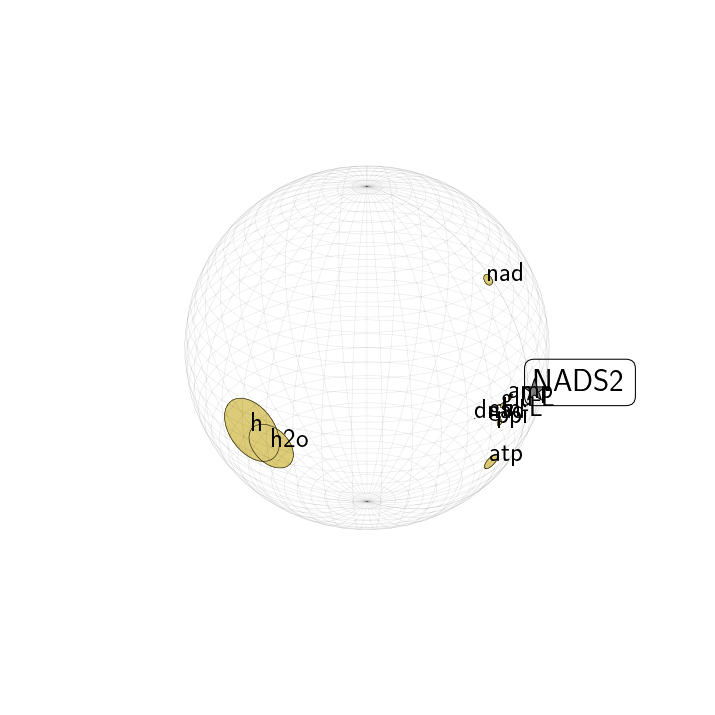

In [602]:
plot_ingredient_compounds_sphere(10148, "NADS2", g, df_nodes_S2, df_features_S2, max_degree=1)

# plt.savefig("/home/rob/Dropbox/Robert/FeatureMercator/Paper/plots/metabolic/NADS2_dim2.pdf")

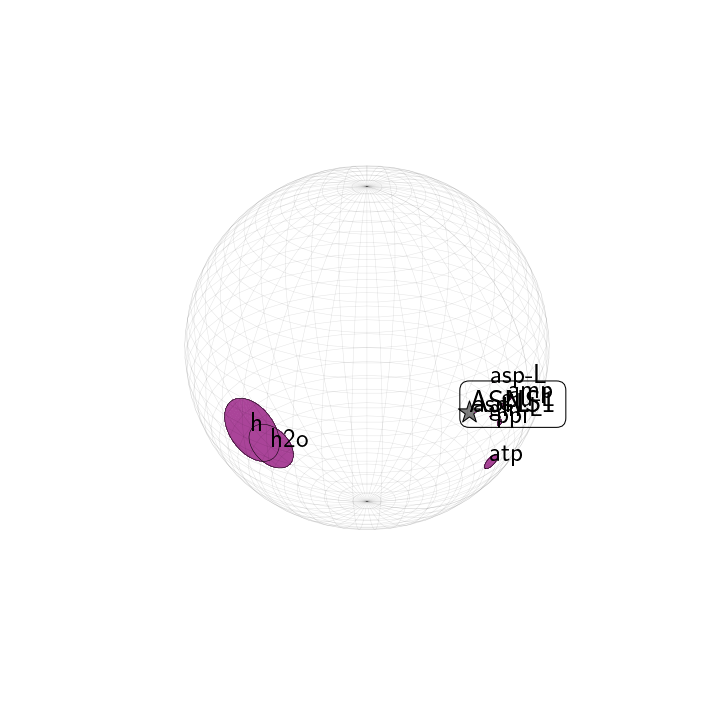

In [597]:
plot_ingredient_compounds_sphere(10044, "ASNS1", g, df_nodes_S2, df_features_S2, max_degree=1)

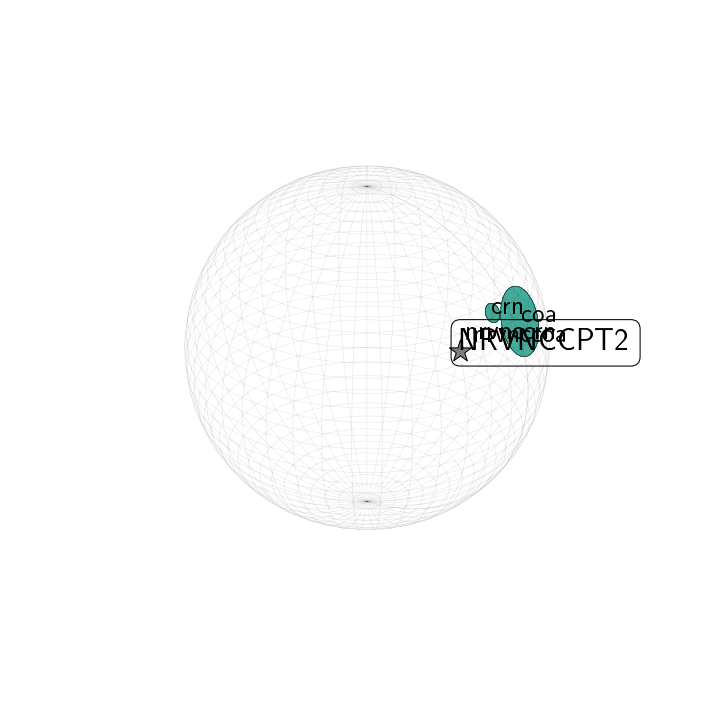

In [598]:
plot_ingredient_compounds_sphere(13184, "NRVNCCPT2", g, df_nodes_S2, df_features_S2, max_degree=1)